In [37]:
from typing import List, Dict, Mapping, Tuple

import chex
import jax
import jax.numpy as jnp
import jax.random as jrand
import flax.linen as nn
from flax.training import train_state  # Useful dataclass to keep train state
import optax
import tensorflow as tf
import pdb
import functools

def println(*args):
  for arg in args:
    print(arg)


In [38]:
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()
# jax.devices()

In [39]:
DEVICE_COUNT = len(jax.devices())
DEVICE_COUNT

1

In [40]:
BATCH_SIZE = 32

## Dataset pipline

In [41]:
import tensorflow as tf

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert the labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Create a TensorFlow data pipeline for the training set
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .shuffle(buffer_size=5000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    .as_numpy_iterator())

# Create a TensorFlow data pipeline for the test set.
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    .as_numpy_iterator())

def get_batch(training: bool = True):
  images, labels = (
      next(train_dataset) if training
      else next(test_dataset))

  images, labels = jnp.array(images), jnp.array(labels)
  images = jnp.reshape(images, (BATCH_SIZE, -1)) # flatten the images
  return images, labels

### test get_batch

In [42]:
test_images, test_labels = get_batch()
test_images.shape, test_labels.shape

((32, 784), (32, 10))

## Modeling

In [43]:
class Autoencoder(nn.Module):
    def setup(self):
      self._encoder = nn.Sequential([
        nn.Dense(512),
        nn.relu,
        nn.Dense(256),
        nn.relu,
        nn.Dense(128),
        nn.relu,
        nn.Dense(64) # latent representation
      ])

      self._decoder = nn.Sequential([
          nn.Dense(128),
          nn.relu,
          nn.Dense(256),
          nn.relu,
          nn.Dense(512),
          nn.relu,
          nn.Dense(784), # reconstructed image
      ])
    @nn.compact
    def __call__(self, x, training: bool = False):
        # Encoder
        encoded = self._encoder(x)

        # Decoder
        decoded = self._decoder(encoded)
        return decoded


### test patches

In [44]:
test_image, test_label = test_images[0], test_labels[0]
test_image.shape

(784,)

## Modeling contd.

In [36]:
class TrainState(train_state.TrainState):
  key: jax.random.KeyArray


random_key = jax.random.PRNGKey(99)
random_key, random_subkey = jax.random.split(random_key)

model = Autoencoder()


output, params = model.init_with_output(jrand.PRNGKey(99), test_image, training=False)
params = params["params"]


<ipython-input-36-0ee0ba59b706>:2: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  key: jax.random.KeyArray


In [45]:
def model_apply(params, inputs):
  return model.apply({"params": params}, inputs, False)

model_apply_batch = jax.vmap(model_apply, in_axes=(None, 0), out_axes=(0))

def forward_pass(params, state, batch):
  inputs, _ = batch
  reconstructed = state.apply_fn(params, inputs)
  loss = (inputs - reconstructed) ** 2
  loss = loss.mean()
  return loss

def train_step(state, batch):
  grad_fn = jax.value_and_grad(forward_pass, argnums=(0))  # differentiate wrt 0th pos argument.
  loss, grads = grad_fn(state.params, state, batch)
  state = state.apply_gradients(grads=grads)
  return state, loss

opt = optax.adam(learning_rate=0.0001)
state = TrainState.create(apply_fn=model_apply_batch, params=params, tx=opt, key=random_key)

In [48]:
for epoch in range(1000):
  batch = get_batch()

  state, loss = train_step(state, batch)
  print("loss", loss, "epoch", epoch) if epoch%100==0 else None

loss 0.07587297 epoch 0
loss 0.051324524 epoch 100
loss 0.03916998 epoch 200
loss 0.03671864 epoch 300
loss 0.0314439 epoch 400
loss 0.025674423 epoch 500
loss 0.02732567 epoch 600
loss 0.027012102 epoch 700
loss 0.024051957 epoch 800
loss 0.025080573 epoch 900


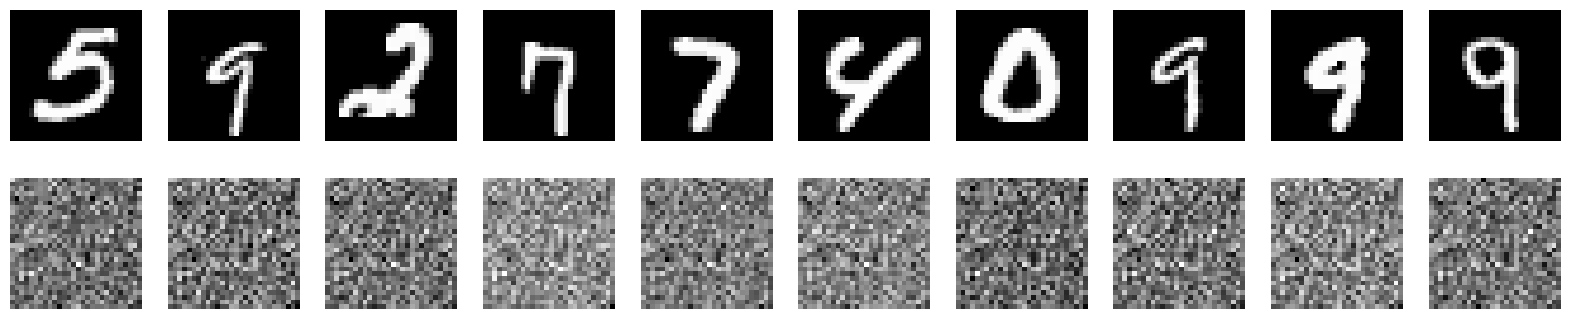

In [49]:
import matplotlib.pyplot as plt

def plot_reconstructions(model, params, batch, n=10):
    inputs, _ = batch
    reconstructed = model_apply_batch(params, inputs)
    fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
    for i in range(n):
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

# Visualize some reconstructions
plot_reconstructions(model, params, get_batch())
